In [1]:
import os
import sys

import blosc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
from collections import OrderedDict
%matplotlib inline

sys.path.append('..')
from se_resnet import SEResNet
from dataset import Dataset, DatasetIndex

### Load data

In [2]:
src = './../MNIST_data'
with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    images = blosc.unpack_array(file.read()).reshape(-1, 28, 28)
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    labels = blosc.unpack_array(file.read())

### Create dataset

In [3]:
ix = DatasetIndex(range(65000))
dset = Dataset(ix, SEResNet)
dset.cv_split()

### train models 

In [4]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

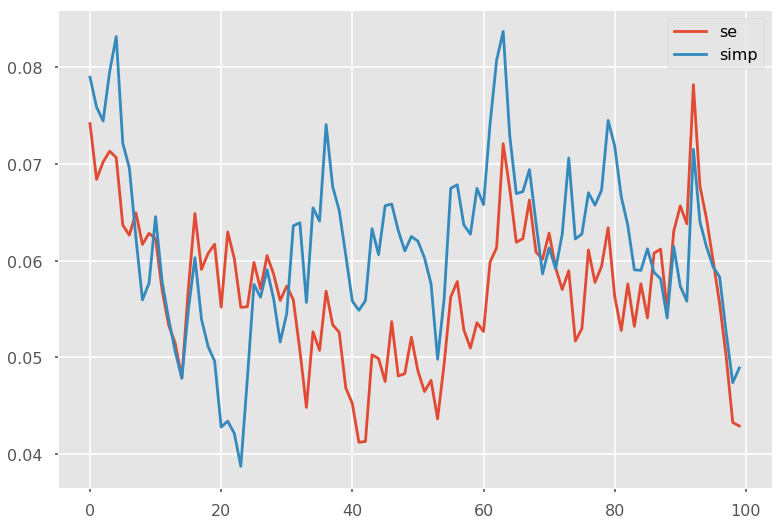

In [6]:
from IPython.display import clear_output
from pandas import ewma
se_loss, bottle_loss = [], []
se_acc, bottle_acc = [], []
bottle_time, se_time = np.zeros(1), np.zeros(1)
train_pipeline = (dset.train.
                 p.
                 train_bottle([images, labels], bottle_loss, bottle_time).
                 train_se([images, labels], se_loss, se_time))
test_pipeline = (dset.test.p
                .import_model("bottlenet", train_pipeline)
                .import_model("seResNet", train_pipeline) 
                .accuracy_se([images, labels], se_acc)
                .accuracy_bottle([images, labels], bottle_acc))
for i in tqn(range(500)):
    train_pipeline.next_batch(300, n_epochs=None, shuffle=2)
    test_pipeline.next_batch(300, n_epochs=None, shuffle=2)
    if i%10==0:
        clear_output(True)
        plt.plot(ewma(np.array(se_loss[-100:]),span=10,adjust=False), label='se')
        plt.plot(ewma(np.array(bottle_loss[-100:]),span=10,adjust=False), label='simp')
       # plt.grid()
        plt.legend()
        plt.show()

In [21]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')
from IPython.display import clear_output
from pandas import ewma
def draw(bottle_loss, stochastic_loss, y, bound=[0, 500, 0, 1]):
    """ Draw graphs to compare models. The graph shows a comparison of the average 
        values calculated with a window in 10 values.
    Args:
        freeze_loss: List with loss value in resnet and freezeout model
        res_loss: List with loss value in clear resnet
        src: List with parameters of model with FreezeOut
        ax: Plt sublot """
    bl_loss = ewma(np.array(bottle_loss),span=50,adjust=False)
    st_loss = ewma(np.array(stochastic_loss),span=50,adjust=False)
    
    plt.plot(bl_loss, label='Bottle {}'.format(y))
    plt.plot(st_loss, label='Squeeze and excitation {}'.format(y))
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel(y, fontsize=16)
    plt.legend(fontsize=14)
    plt.axis(bound)


/home/anton/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  del sys.path[0]
/home/anton/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


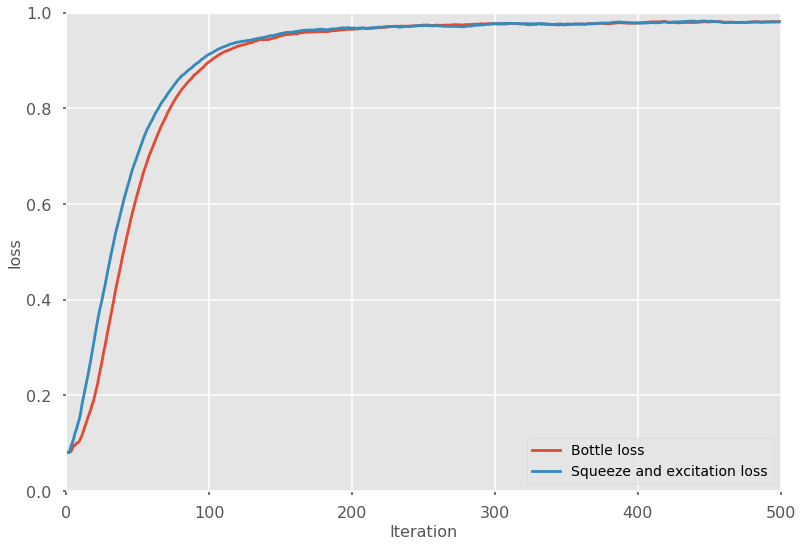

In [22]:
draw(np.array(list(map(list,bottle_acc)))[:,0], np.array(list(map(list,se_acc)))[:,0] , 'loss')

/home/anton/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  del sys.path[0]
/home/anton/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


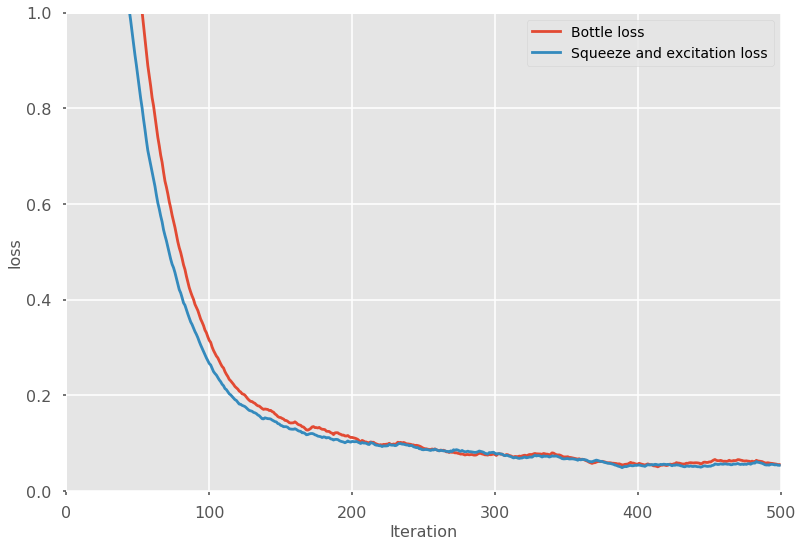

In [23]:
draw(bottle_loss, se_loss , 'loss')

/home/anton/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  del sys.path[0]
/home/anton/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


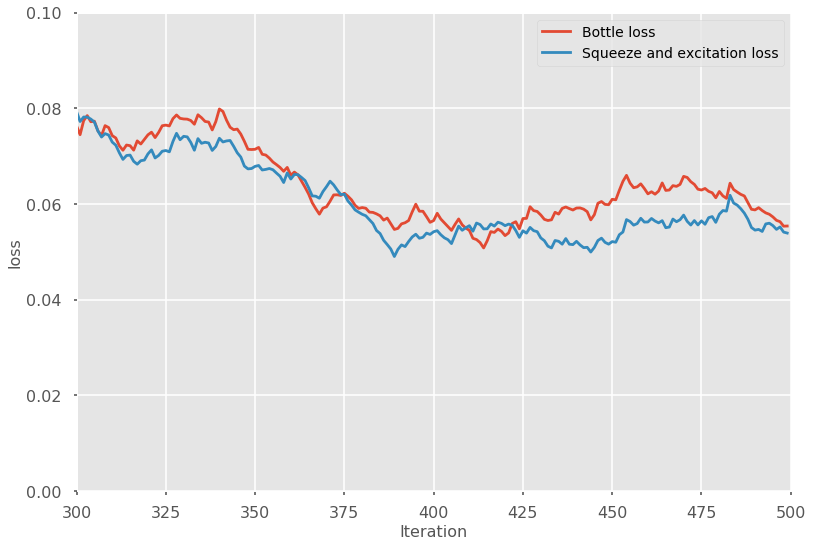

In [24]:
draw(bottle_loss, se_loss, 'loss', [300, 500, 0, 0.1])